## from raw patient timelines to stability analysis and cluster prediction

In [1]:
import pandas as pd
import numpy as np
import math
import random

import os
from os import path


import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Progress bar
from tqdm.notebook import tqdm

# Word Counter
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import pprint
pp = pprint.PrettyPrinter(indent=4)
import scipy.stats as ss
import itertools

#### functions used in this pipeline are locally imported  

In [2]:
## local imports
from  CommonFunctions import *
from Constants import *

### set numbers of target topics

In [3]:
topics_count = 4
# Note: num_topics attempted: 20, 15, 10, 5, 6, ,7 , 8, 4

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Pipeline execution

## load the binary patient x disease matrix and create the bag of words to feed LDA

In [6]:
## use cached pickle files if available 
## for bows
## for list_of_ltcs


if path.exists(BOWs) and not FORCE_RECOMPUTE:
    with open(BOWs, 'rb') as f:
      bows =  pickle.load(f)
    print('loaded BOW list [{0}] from cache'.format(BOWs))

    with open(LTCs, 'rb') as f:
      list_of_ltcs =  pickle.load(f)
    print('loaded LTC list [{0}] from cache'.format(LTCs))
    
else:
    LTC_BINARY = DATA_PATH+'reference/ltc_matrix_binary_mm4.tsv'
    ltc_patients = pd.read_csv(LTC_BINARY, sep = '\t')
    bows, list_of_ltcs = create_bows(ltc_patients)
    
print("working with {0} bows (= patients)".format(len(bows)))

loaded BOW list [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/BOWs.pkl] from cache
loaded LTC list [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/LTCSs.pkl] from cache
working with 143168 bows (= patients)


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## load the raw MLTC sequences and create stages for each patient

computes `stagesPerPatient` which is used by `computeTrajectoryAssociations()`

this break downs a sequence of LTC codes into its stages, for instance:

- codes =  ['OA', 'skin_ulcer', 'dermatitis']
- stages = [['OA'], ['OA', 'skin_ulcer'], ['OA', 'skin_ulcer', 'dermatitis']]

In [6]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
if os.path.isfile(STAGES_PER_PATIENT) and not FORCE_RECOMPUTE:
    print("opening from {}".format(STAGES_PER_PATIENT))
    with open(STAGES_PER_PATIENT, 'rb') as f:
      stagesPerPatient =  pickle.load(f)
    print('loaded StagesPerPatients [{0}] from cache'.format(STAGES_PER_PATIENT))
else:
    print("computing stagesPerPatient from scratch...")
    allSequences = pd.read_csv(RAW_MLTC_SEQUENCES, sep = '\t')
    
    ## limit for testing purposes
    maxPatients = 10000000
    
    stagesPerPatient = computeStagesPerPatient(allSequences[0:maxPatients])  ## for testing use: allSequences[0:maxPatients]  

    ## cache for future use
    with open(STAGES_PER_PATIENT, 'wb') as f:
        pickle.dump(stagesPerPatient, f)    
    
    print("{} patients processed".format(len(stagesPerPatient.keys())))


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


opening from /Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/SPP.pkl
loaded StagesPerPatients [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/SPP.pkl] from cache


In [8]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### summary stats about our bags of words

In [9]:
all_len = 0

for text in bows:
    all_len += len(text)
    
avg_len = all_len/len(bows)

print("All words: {n}".format(n=all_len))
print("Average LTCs per patient: {n}".format(n=avg_len))
print("Maximum amount of LTCs: {n}".format(n= max(len(x) for x in bows)))
print("Minimum amount of LTCs: {n}".format(n= min(len(x) for x in bows)))
print("Patients in corpus: {l}".format(l=len(bows)))
print("Example of patient record:\n {n}".format(n=bows[random.randint(1,143000)]))

All words: 1104514
Average LTCs per patient: 7.714810572194904
Maximum amount of LTCs: 37
Minimum amount of LTCs: 4
Patients in corpus: 143168
Example of patient record:
 ['hypertension', 'depression', 'alcohol_depend', 'diverticular', 'Subarach', 'subdural_haem', 'PTSD', 'migraine']


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/npm65/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


### distribution of disease terms in the corpus

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/npm65/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


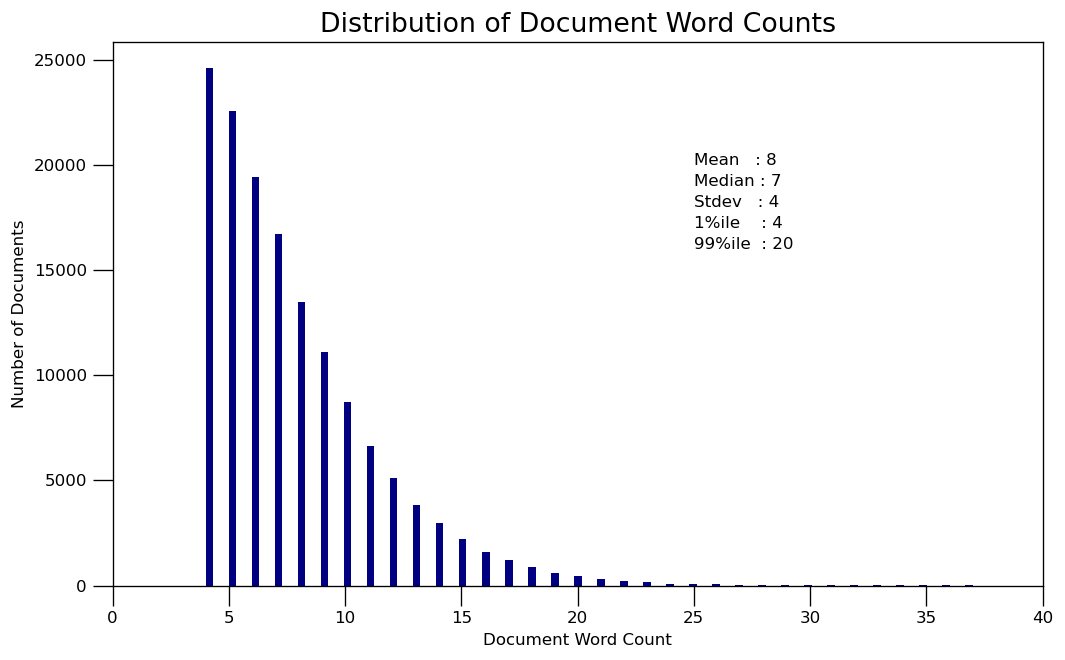

In [10]:
doc_lens = [len(d) for d in bows]

# Plot
plt.figure(figsize=(10,6), dpi=120)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(25, 20000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(25,  19000, "Median : " + str(round(np.median(doc_lens))))
plt.text(25,  18000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(25,  17000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(25,  16000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 40), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,40,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=16))
plt.show()

## Topics generation

### load / generate topic model

In [11]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
## suffix the base file name
TARGET_DIR = TOPICS_COUNTS_PATH + str(topics_count)

if not os.path.exists(TARGET_DIR):
    os.mkdir(TARGET_DIR)

LDA_MODEL_SUFF = TARGET_DIR + "/"+ path.basename(LDA_MODEL).split('.')[0]+ "_"+ str(topics_count)+"."+path.basename(LDA_MODEL).split('.')[1]

if path.exists(LDA_MODEL_SUFF) and not FORCE_RECOMPUTE:
    with open(LDA_MODEL_SUFF, 'rb') as f:
      lda_model = pickle.load(f)
      print('loaded model [{0}] from cache'.format(LDA_MODEL_SUFF))

else:
    lda_model = bagOfWords2Topics(bows, topics_count)    
    ## cache for future use
    with open(LDA_MODEL_SUFF, 'wb') as f:
        pickle.dump(lda_model, f)
        print("model saved to: {0}".format(LDA_MODEL_SUFF))



loaded model [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/4/lda_model_4.pkl] from cache


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### compute dataframe where term lists per topic are corrected using rwidf (relative weight + tf-idf)

this is the main dataframe we will use to track patient associations given their BOWs

In [13]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
## use cached pickle file is available 

if path.exists(TERMS_REL_WEIGHTS_IDF) and not FORCE_RECOMPUTE:
    terms_topics_df = pd.read_csv(TERMS_REL_WEIGHTS_IDF)
    weighted_topics_columns = genWeightedTopicsColumns(topics_count)
    print('loaded terms_topics_df [{0}] from cache'.format(TERMS_REL_WEIGHTS_IDF))
    print('topic column names: {}'.format(weighted_topics_columns))
else:
    print("computing compute_terms_topics_associations from scratch...")
    terms_topics_df, weighted_topics_columns = compute_terms_topics_associations(lda_model, topics_count, list_of_ltcs.columns, bows)
    print("done")
    terms_topics_df.to_csv(TERMS_REL_WEIGHTS_IDF)
    print("terms_topics_df saved to: {0}".format(TERMS_REL_WEIGHTS_IDF))


loaded terms_topics_df [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data//terms_rel_weights_idf.csv] from cache
topic column names: ['weighted_topics_0', 'weighted_topics_1', 'weighted_topics_2', 'weighted_topics_3']


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
terms_topics_df

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,MLTC,topics_0,topics_1,topics_2,topics_3,idf,sums,weighted_topics_0,weighted_topics_1,weighted_topics_2,weighted_topics_3,term_occurrences
0,0,ADHD,0.000002,0.000004,0.000008,0.000992,3.298513,0.001006,0.002105,0.004432,0.007511,0.985952,48821
1,1,BAD,0.000002,0.000004,0.000009,0.013596,2.109351,0.013611,0.000163,0.000315,0.000656,0.998865,16776
2,2,BPH,0.000002,0.035403,0.000007,0.000019,1.160299,0.035432,0.000068,0.999202,0.000190,0.000540,43201
3,3,CCD,0.000003,0.004850,0.000008,0.000018,2.002031,0.004879,0.000548,0.994170,0.001565,0.003717,9786
4,4,CHD,0.000003,0.051889,0.000008,0.023748,0.950506,0.075648,0.000037,0.685932,0.000105,0.313926,11218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,198,varices_portal_hypert,0.000002,0.000004,0.000006,0.004064,2.614267,0.004077,0.000552,0.001091,0.001541,0.996816,71
199,199,venous_lymphatic,0.025347,0.010391,0.002138,0.000036,0.905719,0.037913,0.668554,0.274084,0.056400,0.000962,32
200,200,venous_thromb,0.004334,0.010404,0.000015,0.000054,1.427005,0.014806,0.292689,0.702677,0.000981,0.003654,24
201,201,vitb12_deficiency,0.005842,0.000070,0.000014,0.020433,1.454019,0.026358,0.221628,0.002641,0.000529,0.775201,19


### generate word clouds for the topics

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


column: sums


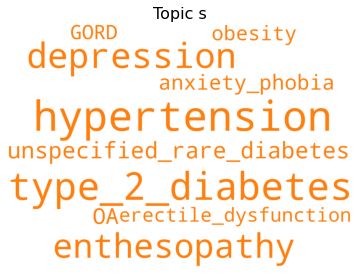

saved to /Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/4/wordCloud_1
column: weighted_topics_0


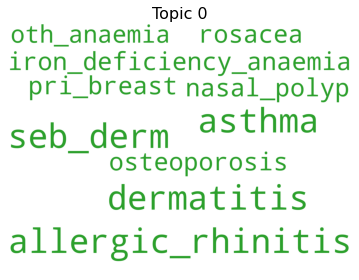

saved to /Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/4/wordCloud_2
column: weighted_topics_1


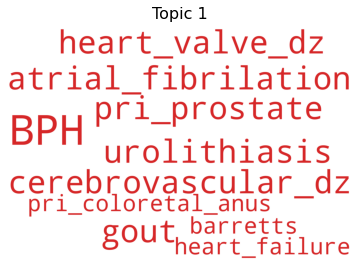

saved to /Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/4/wordCloud_3
column: weighted_topics_2


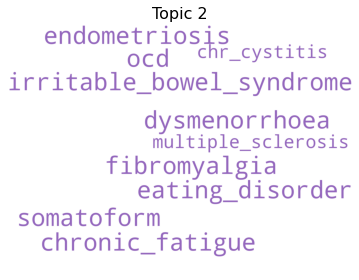

saved to /Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/4/wordCloud_4


In [16]:
createWordClouds(terms_topics_df, topics_count)

## compute the tensor that holds the patient-topic association __for each stage in the patient's history__


In [35]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### next cell will take 30+ minutes to compute from scratch

In [34]:
##

## save main trajectories data structure
TARGET_DIR = TOPICS_COUNTS_PATH + str(topics_count)

if not os.path.exists(TARGET_DIR):
    os.mkdir(TARGET_DIR)

ALL_TRAJECTORIES_SUFF = TARGET_DIR +  "/"+ path.basename(ALL_TRAJECTORIES).split('.')[0]+ "_"+ str(topics_count)+"."+path.basename(ALL_TRAJECTORIES).split('.')[1]

print("looking for cached file in [{0}]".format(ALL_TRAJECTORIES_SUFF))
if path.exists(ALL_TRAJECTORIES_SUFF):
    print("cached file found")
else:
    print("cached file NOT found")

if path.exists(ALL_TRAJECTORIES_SUFF) and not FORCE_RECOMPUTE:
    with open(ALL_TRAJECTORIES_SUFF, 'rb') as f:
      trajectories =  pickle.load(f)
      print('loaded trajectories [{0}] from cache'.format(ALL_TRAJECTORIES))

else:
    print("starting computation of *all* trajectories for {0} bows (= patients)".format(len(bows)))
    print("{} keys in stagesPerPatient".format(len(stagesPerPatient.keys())))
    trajectories = computeTrajectoryAssociations(stagesPerPatient, terms_topics_df, weighted_topics_columns, topics_count)

    with open(ALL_TRAJECTORIES_SUFF, 'wb') as f:
        pickle.dump(trajectories, f)
        print("trajectories saved to {0}".format(ALL_TRAJECTORIES_SUFF))


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


looking for cached file in [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/DPTA/data/generated/4/trajectories_4.pkl]
cached file found
starting computation of *all* trajectories for 143168 bows (= patients)
210210 keys in stagesPerPatient
1000 patients processed
2000 patients processed
3000 patients processed
4000 patients processed
5000 patients processed
6000 patients processed
7000 patients processed
8000 patients processed
9000 patients processed
10000 patients processed
11000 patients processed
12000 patients processed
13000 patients processed
14000 patients processed
15000 patients processed
16000 patients processed
17000 patients processed
18000 patients processed
19000 patients processed
20000 patients processed
21000 patients processed
22000 patients processed
23000 patients processed
24000 patients processed
25000 patients processed
26000 patients processed
27000 patients processed
28000 patients processed
29000 patients processed
30000 patients processed
31